In [2]:
import torch

torch.cuda.empty_cache()

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Script d'entraînement de Flan-T5-large en 8-bit (QLoRA), optimisé pour ~10 250 Q/R.
- Quantization 8-bit + QLoRA (r=16, alpha=64, lora_dropout=0.0)
- Batch GPU = 6, gradient_accumulation_steps = 2 (batch effectif ×8 pour ~5 Go VRAM)
- Learning rate = 3e-4, epochs max = 8, patience EarlyStopping = 3
- Scheduler = cosine, warmup_ratio = 0.10
- Optimiseur = AdamW
- Weight decay = 0.01, max_grad_norm = 1.0
- Label smoothing = 0.1, fp16=False, bf16=False
- Generation: beams=4, generation_max_length=200
- Gradient checkpointing activé pour économiser la mémoire GPU
"""

import os
import warnings
import random
import numpy as np
import torch
import nltk
from datasets import load_dataset
from evaluate import load as load_metric
from transformers import (
    T5Config,
    T5Tokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback,
    BitsAndBytesConfig
)
from peft import get_peft_model, LoraConfig, prepare_model_for_kbit_training

# ─── 0) Debug CUDA ───────────────────────────────────────────────
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

# ─── 1) GPU ───────────────────────────────────────────────────────
assert torch.cuda.is_available(), "CUDA n'est pas disponible"
torch.cuda.set_device(0)

# ─── 2) Offline & warnings ────────────────────────────────────────
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["BITSANDBYTES_NOWELCOME"] = "1"
warnings.filterwarnings("ignore", message=".*should be passed explicitly.*")

# ─── 3) Seed ─────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ─── 4) Dataset ──────────────────────────────────────────────────
dataset = load_dataset("json", data_files={"full": "dataset_full.json"}, split="full")
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset, test_dataset = splits["train"], splits["test"]
print(f"Train: {len(train_dataset)} exemples, Test: {len(test_dataset)} exemples")

# ─── 5) Tokenizer & modèle 8-bit QLoRA ────────────────────────────
model_name = "google/flan-t5-large"
tokenizer = T5Tokenizer.from_pretrained(model_name, local_files_only=True)
config = T5Config.from_pretrained(
    model_name,
    dropout_rate=0.10,
    attention_dropout_rate=0.10,
    local_files_only=True
)

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=0.0
)
base_model = T5ForConditionalGeneration.from_pretrained(
    model_name,
    config=config,
    quantization_config=bnb_config,
    device_map="auto",
    local_files_only=True
)
base_model = prepare_model_for_kbit_training(base_model)
base_model.config.use_cache = False

# ─── 6) LoRA ─────────────────────────────────────────────────────
peft_config = LoraConfig(
    r=16,
    lora_alpha=64,
    target_modules=["q", "v"],
    lora_dropout=0.0,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(base_model, peft_config).to("cuda")

# ─── 7) Data collator ────────────────────────────────────────────
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100
)

# ─── 8) Prétraitement ────────────────────────────────────────────
nltk.download("punkt", quiet=True)
PREFIX = "Veuillez répondre à la question suivante : "
def preprocess_function(examples):
    inputs = [PREFIX + instr for instr in examples["instruction"]]
    model_inputs = tokenizer(
        inputs, max_length=200, truncation=True, padding="max_length"
    )
    labels = tokenizer(
        text_target=examples["response"],
        max_length=200, truncation=True, padding="max_length"
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_tok = train_dataset.map(
    preprocess_function, batched=True, remove_columns=train_dataset.column_names
)
test_tok = test_dataset.map(
    preprocess_function, batched=True, remove_columns=test_dataset.column_names
)

# ─── 9) ROUGE ─────────────────────────────────────────────────────
rouge = load_metric("rouge")
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(nltk.sent_tokenize(p.strip())) for p in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(l.strip())) for l in decoded_labels]
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: v * 100 for k, v in result.items()}

# ─── 10) Arguments d'entraînement ─────────────────────────────────
training_args = Seq2SeqTrainingArguments(
    output_dir="./flan_t5_large_qlora_optim",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    gradient_accumulation_steps=2,
    num_train_epochs=8,
    warmup_ratio=0.10,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    max_grad_norm=1.0,
    label_smoothing_factor=0.1,
    adafactor=False,                     # AdamW
    fp16=False,
    bf16=False,
    gradient_checkpointing=True,
    generation_num_beams=4,
    generation_max_length=200,
    predict_with_generate=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_strategy="steps",
    logging_steps=100,
    remove_unused_columns=False,
    label_names=["labels"]
)

# ─── 11) Trainer avec EarlyStopping ───────────────────────────────
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ─── 12) Lancer ───────────────────────────────────────────────────
torch.cuda.empty_cache()
trainer.train()


/home/abdou/anaconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-07 16:25:21.894409: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 16:25:22.655660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is

Train: 8209 exemples, Test: 2053 exemples


/tmp/ipykernel_1999/3394428598.py:169: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/home/abdou/anaconda3/envs/myenv/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.472700,2.352371,24.380422,15.191055,21.850573,22.065877
2,2.405000,2.316655,26.150178,16.448814,23.382362,23.666405
3,2.359800,2.240150,26.810525,17.035597,24.162231,24.431005
4,2.341900,2.233765,29.725725,19.082151,26.727012,27.032919
5,2.318800,2.220972,30.050865,19.357539,26.994733,27.325815
6,2.317400,2.218883,29.378177,18.867876,26.225849,26.631023
7,2.309400,2.207351,29.843767,19.167269,26.716775,27.037137
8,2.310200,2.205076,30.178123,19.383652,26.969792,27.298034


/home/abdou/anaconda3/envs/myenv/lib/python3.9/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in google/flan-t5-large - will assume that the vocabulary was not modified.
  warnings.warn(
/home/abdou/anaconda3/envs/myenv/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/abdou/anaconda3/envs/myenv/lib/python3.9/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in google/flan-t5-large - will assume that the vocabulary was not modified.
  warnings.warn(
/home/abdou/anaconda3/envs/myenv/lib/python3.9/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will 

TrainOutput(global_step=5480, training_loss=3.0903541592785913, metrics={'train_runtime': 170692.5525, 'train_samples_per_second': 0.385, 'train_steps_per_second': 0.032, 'total_flos': 5.94963555876864e+16, 'train_loss': 3.0903541592785913, 'epoch': 8.0})

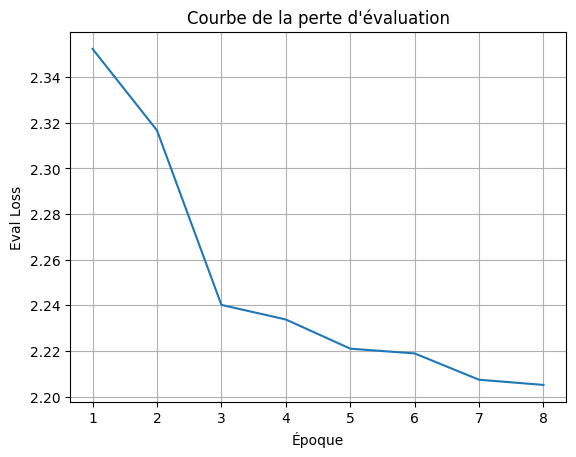

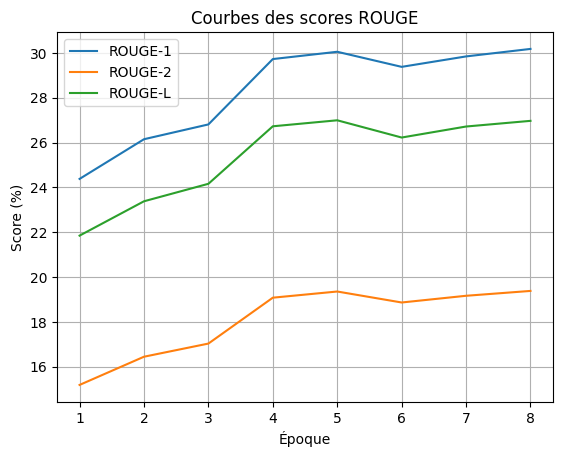

In [4]:

# ------------------------------------------------------------------------
# 14) Tracé des courbes de loss et de ROUGE
# ------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Récupération de l’historique des logs
history = trainer.state.log_history

# --- Courbe de perte d’entraînement ---
# On extrait les tuples (step, loss)
train_loss = [(entry["step"], entry["loss"])
              for entry in history
              if "loss" in entry and "epoch" not in entry]

if train_loss:
    steps, losses = zip(*train_loss)
    plt.figure()
    plt.plot(steps, losses)
    plt.title("Courbe de la perte d'entraînement")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# --- Courbe de perte d’évaluation par époque ---
# On extrait (epoch, eval_loss)
eval_loss = [(entry["epoch"], entry["eval_loss"])
             for entry in history
             if "eval_loss" in entry]

if eval_loss:
    epochs, losses_eval = zip(*eval_loss)
    plt.figure()
    plt.plot(epochs, losses_eval)
    plt.title("Courbe de la perte d'évaluation")
    plt.xlabel("Époque")
    plt.ylabel("Eval Loss")
    plt.grid(True)
    plt.show()

# --- Courbes des scores ROUGE par époque ---
# Extraction des métriques ROUGE (1, 2 et L)
rouge1 = [(entry["epoch"], entry["eval_rouge1"])
          for entry in history
          if "eval_rouge1" in entry]
rouge2 = [(entry["epoch"], entry["eval_rouge2"])
          for entry in history
          if "eval_rouge2" in entry]
rougeL = [(entry["epoch"], entry["eval_rougeL"])
          for entry in history
          if "eval_rougeL" in entry]

if rouge1 or rouge2 or rougeL:
    plt.figure()
    if rouge1:
        e1, v1 = zip(*rouge1)
        plt.plot(e1, v1, label="ROUGE-1")
    if rouge2:
        e2, v2 = zip(*rouge2)
        plt.plot(e2, v2, label="ROUGE-2")
    if rougeL:
        eL, vL = zip(*rougeL)
        plt.plot(eL, vL, label="ROUGE-L")
    plt.title("Courbes des scores ROUGE")
    plt.xlabel("Époque")
    plt.ylabel("Score (%)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Script de test pour Flan-T5 fine-tuné avec QLoRA, reprenant le prompt
d'entraînement et chargeant/vérifiant tous les composants du checkpoint.
"""
import os
import re
import json
import random
import torch
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import PeftModel

# 1) Répertoire racine des checkpoints
checkpoint_root = "flan_t5_large_qlora_optim"
if not os.path.isdir(checkpoint_root):
    raise FileNotFoundError(f"Répertoire introuvable : {checkpoint_root}")

# 2) Sélection du dernier checkpoint
checkpoint_dirs = [d for d in os.listdir(checkpoint_root) if re.match(r"checkpoint-\d+", d)]
if not checkpoint_dirs:
    raise ValueError("Aucun dossier de checkpoint trouvé.")
latest_ckpt = f"checkpoint-{max(int(d.split('-')[-1]) for d in checkpoint_dirs)}"
ckpt_path = Path(checkpoint_root) / latest_ckpt
print(f"Checkpoint détecté : {latest_ckpt}")

# 3) Vérification des fichiers clés
files_to_check = [
    "adapter_config.json",
    "adapter_model.safetensors",
    "added_tokens.json",
    "special_tokens_map.json",
    "tokenizer_config.json",
    "spiece.model",
    "trainer_state.json",
    "training_args.bin",
    "optimizer.pt",
    "rng_state.pth",
    "scheduler.pt",
]
print("\nVérification des fichiers du checkpoint :")
for fname in files_to_check:
    status = "OK" if (ckpt_path / fname).exists() else "MANQUANT"
    print(f"  - {fname}: {status}")

# 4) Chargement du tokenizer
print("\nChargement du tokenizer…")
tokenizer = AutoTokenizer.from_pretrained(
    str(ckpt_path),
    local_files_only=True,
    use_fast=True
)
print(f"Tokenizer chargé depuis {ckpt_path}")

# 5) Chargement du modèle de base et application de LoRA
print("Chargement du modèle de base…")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large", local_files_only=True)
print("Application de l’adaptateur LoRA…")
model = PeftModel.from_pretrained(
    model,
    ckpt_path,
    local_files_only=True,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
model.eval()

# 6) Récupération des paramètres de génération
train_args_path = ckpt_path / "training_args.bin"
gen_max = None
if train_args_path.exists():
    try:
        train_args = torch.load(train_args_path, map_location="cpu", weights_only=False)
        gen_max = getattr(train_args, 'generation_max_length', None) or getattr(train_args, 'max_length', None)
        print(f"generation_max_length trouvé: {gen_max}")
    except Exception as e:
        print(f"⚠️ Impossible de charger training_args.bin : {e}")

# 7) Préfixe cohérent avec l’entraînement
PREFIX = "Veuillez répondre à la question suivante : "

# 8) Préparation du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Modèle déplacé sur {device}.")

# 9) Chargement des données
data_file = "exemples.json"
if not os.path.isfile(data_file):
    raise FileNotFoundError(f"Fichier de données introuvable : {data_file}")
with open(data_file, "r", encoding="utf-8") as f:
    data = json.load(f)
assert isinstance(data, list), "Le dataset doit être une liste JSON"
print(f"{len(data)} exemples chargés.")
samples = random.sample(data, 10)

# 10) Génération des réponses
print("\n--- Génération de réponses pour 10 exemples aléatoires ---\n")
for idx, ex in enumerate(samples, 1):
    instr = ex.get("instruction", "").strip()
    if not instr:
        continue
    inputs = tokenizer(PREFIX + instr, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=gen_max or 150,
            repetition_penalty=1.2,
            no_repeat_ngram_size=2,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )
    resp = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Exemple {idx} :\n  Instruction : {instr}\n  Réponse : {resp}\n{'-'*60}")


/home/abdou/anaconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-19 15:11:10.719126: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 15:11:11.943370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Checkpoint détecté : checkpoint-5480

Vérification des fichiers du checkpoint :
  - adapter_config.json: OK
  - adapter_model.safetensors: OK
  - added_tokens.json: OK
  - special_tokens_map.json: OK
  - tokenizer_config.json: OK
  - spiece.model: OK
  - trainer_state.json: OK
  - training_args.bin: OK
  - optimizer.pt: OK
  - rng_state.pth: OK
  - scheduler.pt: OK

Chargement du tokenizer…


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Tokenizer chargé depuis flan_t5_large_qlora_optim/checkpoint-5480
Chargement du modèle de base…
Application de l’adaptateur LoRA…
generation_max_length trouvé: 200
Modèle déplacé sur cuda.
207 exemples chargés.

--- Génération de réponses pour 10 exemples aléatoires ---

Exemple 1 :
  Instruction : Dans quel cas le tribunal prononce-t-il le divorce "khôl"?
  Réponse : Le tribunal ne peut, dans le cas de la demande du mari, établir un lien de mariage entre les deux parties.
------------------------------------------------------------
Exemple 2 :
  Instruction : Que doit faire une expertise médicale pour établir l'aptitude du mineur à assumer les charges du mariage ?
  Réponse : Le mineur doit obtenir une expertise médicale pour établir l’aptitude du mineurs à assumer les charges du mariage.
------------------------------------------------------------
Exemple 3 :
  Instruction : Qu'est-ce que l'article 66 ci - après ?
  Réponse : 66 ci – après.
-------------------------------------------